# Data Science Trainee Hands On

## Pendahuluan

### Latar Belakang

Sejak beberapa tahun ke belakang, media sosial menjadi salah satu media penyebaran informasi terbesar yang digunakan di masyarakat. Media sosial memberikan ruang untuk setiap individu dapat melakukan produksi, distribusi, dan konsumsi informasi dengan sangat mudah tanpa mengenal ruang dan waktu. Kemudahan dalam menyampaikan informasi dan berekspresi membuat volume data media sosial menjadi sangat besar. Data ini menyimpan berbagai informasi yang berharga. Salah satu penggunaan media sosial dalam di dalam masyarakat sebagai media diskusi atau sekedar penyampaian opini tentang berbagai isu yang berkembang di masyarakat. 

Kemudahan yang dihadirkan media sosial tidak hanya memberikan dampak yang bersifat positif. Salah satu hal yang paling mudah terlihat adalah mudahnya seseorang untuk melakukan ujaran kebencian (hate speech) terhadap sesama pengguna di media sosial. Hal ini tentunya menjadi masalah yang cukup serius karena memungkinkan terciptanya lingkungan yang buruk bagi masyarakat ketika bermedia sosial. Bukan tidak mungkin banyaknya permasalahan mental yang dialami orang-orang tidak lepas dari kondisi ini. Kondisi ini juga tentunya sangat tidak sesuai dengan budaya Indonesia yang terkenal akan keramahannya antar sesama. Terpisahnya jarak dan tempat yang dihubungkan oleh media sosial rasanya membuat hilangnya budaya masyarakat Indonesia yang selalu sopan dan santun kepada siapa pun.

Efek negatif yang ditimbulkan oleh teknologi seharusnya dapat diatasi oleh pendekatan teknologi pula. Salah satu solusi untuk mengurangi keberadaan ujaran kebencian dan bullying di media sosial adalah dengan melakukan klasifikasi atas pesan yang diterima untuk meniadakan pesan yang diduga mengandung maksud tertentu. Oleh karena itu, permasalahan yang dianalisis dan dicari solusinya pada implementasi ini adalah klasifikasi ujaran kebencian.

Sebelum melakukan pekerjaan utama, dilakukan analisis data teks mengenai topik ini terlebih dahulu. Analisis data dimaksudkan untuk mendapatkan wawasan/insight mengenai data yang dapat membantu dalam menyelesaikan masalah. Analisis dilakukan dengan mengolah data dan juga melakukan visualisasi terhadapnya.

### Deskripsi Permasalahan

Data yang digunakan memiliki 6 label dengan 5 label hate speech (**religion, race, physical, gender, other**) dan 1 label **not hate speech**. Pada implementasinya saya bermaksud untuk menganalisis terlebih dahulu dan akan menentukan apakah akan menggunakan 6 label atau diturunkan menjadi 2 label. 

Data yang digunakan merupakan kumpulan tweet yang memiliki label abusive dan hate speech. Untuk hate speech sendiri memiliki informasi lebih dalam terkait topik atau ranah hate speech-nya dan juga kekuatan dari hate speech-nya. Pada folder dataset juga disediakan kamus typo atau slangword sebagai upaya normalisasi teks tweet yang banyak mengandung kata typo, singkatan, dan gaul. Terdapat juga list kata abusive yang dapat digunakan untuk ekstraksi fitur.


## Data Overview

### Data Preparation

#### Import Pustaka

In [81]:
%matplotlib inline 

import re
import string
import nltk
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from spacy.lang.id.stop_words import STOP_WORDS as STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [82]:
sns.set_style("white")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', None)
warnings.simplefilter(action="ignore", category=FutureWarning)

#### Import Data

In [83]:
df_raw = pd.read_csv("./dataset/data.csv", encoding = "ISO-8859-1")
df_raw.head(3)

Tweet  \
0                                                                                                                      - disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'   
1                                                                                                                                        RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'   
2  41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter   

   HS  Abusive  HS_Individual  HS_Group  HS_Religion  HS_Race  HS_Physical  \
0   1        1              1         0            0        0            0   
1   0        1              0         0            0        0            0   
2   0        0              0         0            0        0            0   

   HS_Gender  HS_Other  HS_Weak  HS_Moderate  HS_Strong  
0          0         1        1            0          0  
1          0         0        0            0          0  
2          0         0        0            0          0

Untuk mempermudah analisis, label yang berbentuk one hot encoding ditranslasikan menjadi bentuk label text. 

In [84]:
def categories_translate(row):
    if (row.HS_Religion):
        return "religion hatespeech"
    elif (row.HS_Race):
        return "race hatespeech"
    elif (row.HS_Physical):
        return "physical hatespeech"
    elif (row.HS_Gender):
        return "gender hatespeech"
    elif (row.HS_Other):
        return "other hatespeech"
    else:
        return "not hatespeech"
    
def target_translate(row):
    if (row.HS_Individual):
        return "individual hatespeech"
    elif (row.HS_Group):
        return "group hatespeech"
    else:
        return "not hatespeech"
    
def severity_translate(row):
    if (row.HS_Weak):
        return "weak hatespeech"
    elif (row.HS_Moderate):
        return "moderate hatespeech"
    elif (row.HS_Strong):
        return "strong hatespeech"
    else:
        return "not hatespeech"

In [85]:
df_raw["hate_speech"] = df_raw.apply(lambda row: "hatespeech" if row.HS else "not hatespeech", axis=1)
df_raw["abusive"] = df_raw.apply(lambda row: "abusive" if row.HS else "not abusive", axis=1)
df_raw["hate_speech_categories"] = df_raw.apply(lambda row: categories_translate(row), axis=1)
df_raw["hate_speech_target"] = df_raw.apply(lambda row: target_translate(row), axis=1)
df_raw["hate_speech_severity"] = df_raw.apply(lambda row: severity_translate(row), axis=1)

df_raw = df_raw.rename(columns={"Tweet": "text"})
df_raw = df_raw.loc[:, ['text', 'hate_speech', "abusive", "hate_speech_categories", "hate_speech_target", "hate_speech_severity"]]

df_raw

text  \
0                                                                                                                          - disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'   
1                                                                                                                                            RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'   
2      41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter   
3                                                                                                                                                                                         USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU'   
4                                                                                                                                                                           USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah'   
...                                                                                                                                                                                                                                                               ...   
13164                                                                                                                                                                                                   USER jangan asal ngomong ndasmu. congor lu yg sekate2 anjyng'   
13165                                                                                                                                                                                                                                    USER Kasur mana enak kunyuk'   
13166                                                                                                                                                                                                  USER Hati hati bisu :( .g\n\nlagi bosan huft \xf0\x9f\x98\xaa'   
13167                                                                                                                         USER USER USER USER Bom yang real mudah terdeteksi bom yang terkubur suatu saat lebih dahsyat ledakannya itulah di sebut Revolusi Jiwa'   
13168                                                                                                                                                                                                           USER Mana situ ngasih(": itu cuma foto ya kutil onta'   

          hate_speech      abusive hate_speech_categories  \
0          hatespeech      abusive       other hatespeech   
1      not hatespeech  not abusive         not hatespeech   
2      not hatespeech  not abusive         not hatespeech   
3      not hatespeech  not abusive         not hatespeech   
4          hatespeech      abusive    religion hatespeech   
...               ...          ...                    ...   
13164      hatespeech      abusive    physical hatespeech   
13165  not hatespeech  not abusive         not hatespeech   
13166  not hatespeech  not abusive         not hatespeech   
13167  not hatespeech  not abusive         not hatespeech   
13168      hatespeech      abusive       other hatespeech   

          hate_speech_target hate_speech_severity  
0      individual hatespeech      weak hatespeech  
1             not hatespeech       not hatespeech  
2             not hatespeech       not hatespeech  
3             not hatespeech       not hatespeech  
4           group hatespeech  moderate hatespeech  
...                      ...   

Teramati bahwa data masih sangat kotor karena diambil dari media sosial sehingga masih memiliki mention, hashtag, hingga url. Diperlukan preprocessing untuk menangani ini.

In [86]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    13169 non-null  object
 1   hate_speech             13169 non-null  object
 2   abusive                 13169 non-null  object
 3   hate_speech_categories  13169 non-null  object
 4   hate_speech_target      13169 non-null  object
 5   hate_speech_severity    13169 non-null  object
dtypes: object(6)
memory usage: 617.4+ KB


#### Missing Values

In [87]:
df_raw.isnull().sum()

text                      0
hate_speech               0
abusive                   0
hate_speech_categories    0
hate_speech_target        0
hate_speech_severity      0
dtype: int64

Tidak terdapat baris data yang memiliki nilai null atau tidak terdefinisi sehingga dapat diproses keseluruhannya.

#### Duplicate Values

In [88]:
df_raw[df_raw.duplicated(keep=False)]

text  \
33                                                                                                                                                             RT USER: Kelakuan homok jaman now, ngentot aja sambil live di Blued #gayvid #gvid #lokalhangat URL   
40                                                                                                                                                           GAPERNAH MENDALAMI AL-QURAN YA BANG??? PANTESAN MULUTNYA KAYA ORANG KAFIR BEJAT HINA farhatabbaslaw'   
43         #GubernurZamanNow #GusIpulPuti2 #GanjarYasin1 #DjarotSihar2 #HasanAnton2 #KosterAce1 #NurdinSudirman3 #KarolinGidot2 RT USER: "Keanekaragaman budaya, suku, agama, itulah sesungguhnya kekayaan kita,â?? tutur Djarot di hadapan peserta Rakercabsuâ?¦   
165    Giat Bhabinkamtibmas Brigpol Mbs Sihombing pd hari ini, Rabu 11 April 2018 melaks sambang desa dan tatap muka sekaligus monitoring Kamtibmas menuju Pilkada 2018 di Desa Lobusiregar I, tepatnya dirumah Rudi Panjaitan, Helman Siahaan dan Hotman Siahaan   
182                                                                                                                                                      USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER   
...                                                                                                                                                                                                                                                           ...   
12793                                                                                                                                                                                                                          I added a video to a USER playlist   
12952                                                                                                                                                    USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER   
12953                                                                                                                                                                 SETUJU SAYA,KLAU AHOK DAPAT GELAR SANTRI KEHORMATAN.... TAPI SANTRI KEHORMATAN BABI.... URL   
12985                                                                                                                                  USER ahmad dhani yang terhormat paling babi paling anjing aing kontol paling lonte tungu saat nya karier mu akan habis!!!!   
13075                                                                                       *Bravoo Presiden Jokowi !ð???* Presiden Joko Widodo (Jokowi) tercatat sudah merampungkan 30 proyek strategis nasional (PSN) yang terhitung sejak 2016-2017. Apa saja?   

          hate_speech      abusive hate_speech_categories  \
33     not hatespeech  not abusive         not hatespeech   
40         hatespeech      abusive    religion hatespeech   
43     not hatespeech  not abusive         not hatespeech   
165    not hatespeech  not abusive         not hatespeech   
182    not hatespeech  not abusive         not hatespeech   
...               ...          ...                    ...   
12793  not hatespeech  not abusive         not hatespeech   
12952  not hatespeech  not abusive         not hatespeech   
12953      hatespeech      abusive       other hatespeech   
12985      hatespeech      abusive      gender hatespeech   
13075  not hatespeech  not abusive         not hatespeech   

          hate_speech_target hate_speech_severity  
33            not hatespeech       not hatespeech  
40     individual hatespeech      weak hatespeech  
43            not hatespeech       not hatespeech  
165           not hatespeech       not hatespeech  
182           not hatespeech       not hatespeech  
...                      ...                  ...  
12793         not hates

Data duplikat dihapus karena jumlahnya tidak terlalu signifikan

In [89]:
df_raw = df_raw[df_raw["text"] != ""]
df_raw = df_raw.drop_duplicates().reset_index()

### Preprocessing
Method preprocessing digunakan untuk mentransformasikan teks pesan dari media sosial menjadi lebih bersih dan tidak lagi mengandung entitas yang kurang diperlukan. Beberapa hal yang dilakukan adalah :
- Lowercasing
- Hapus URL, mention, Hashtag
- Hapus STOPWORDS atau kata yang sangat sering muncuk dan tidak perlu
- Hapus selain huruf sehingga vektor nanti hanya terdiri dari kata

In [105]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

STOPWORDS.update(["saya", "user", "url", "yg", "lo", "ya", "rt", "aja", "nya", "ga", "gak", "orang"])

def show_wordcloud(data):
    words = ''
     
    for sentence in data:
        tokens = str(sentence).split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        words += " ".join(tokens) + " "
     
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 12, stopwords=STOPWORDS).generate(words)
     
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
    plt.show()
    
def show_top_ngram(df_column):
    
    vectorizer = TfidfVectorizer(ngram_range=(2,2))

    ngrams = vectorizer.fit_transform(df_column)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = vectorizer.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'bigram/trigram'})

    return df_ngram

def delete_url(text):
    links = re.findall(re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL), text)
    for link in links:
        text = text.replace(link[0], ' ')    
    return text

def delete_mention_tag(text):
               
    # filter kata yang mengandung penanda mention dan hashtag
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in ['@','#']:
                words.append(word)
    return ' '.join(words)

def preprocessing(text):
    text = text.lower()                    # convert ke lowercase
    text = delete_url(text)                # hapus URL/link
    text = delete_mention_tag(text)        # hapus entitas mention dan hashtags
    text = text.strip()
    text = " ".join([word for word in text.split() if not word in set(['lo', 'yg', 'saya', 'user', 'url'])]) 
    text = re.sub(r" \d+ ", " ", text)     # hapus digit
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"[^a-z ]", "", text)
    text = re.sub(r"  ", " ", text)
    return text

In [106]:
df_raw['text'] = df_raw.apply(lambda row: preprocessing(row.text), axis=1)

In [107]:
df_raw.head(3)

df_index  \
0         0   
1         1   
2         2   

                                                                                                                                                                                                                                                   text  \
0                                                                                                                          disaat semua cowok berusaha melacak perhatian gue loe lantas remehkan perhatian gue kasih khusus ke elo basic elo cowok bego   
1                                                                                                                                           rt siapa yang telat ngasih tau eluedan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga   
2  kadang aku berfikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkalikali kadang aku merasa tuhan itu ninggalkan aku sendirian ketika orangtuaku berencana berpisah ketika kakakku lebih memilih jadi kristen ketika aku anak ter   

      hate_speech      abusive hate_speech_categories     hate_speech_target  \
0      hatespeech      abusive       other hatespeech  individual hatespeech   
1  not hatespeech  not abusive         not hatespeech         not hatespeech   
2  not hatespeech  not abusive         not hatespeech         not hatespeech   

  hate_speech_severity  text_length  
0      weak hatespeech           20  
1       not hatespeech           20  
2       not hatespeech           36

## Exploratory Data Analysis

### Distribusi Label

#### Distribusi Label Hate Speech

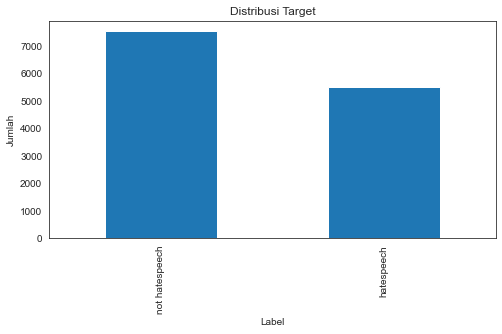

In [108]:
df_raw['hate_speech'].value_counts().plot.bar(figsize=(8, 4));

plt.title('Distribusi Target');
plt.xlabel('Label');
plt.ylabel('Jumlah');

Distribusi label kelas hatespeech dan not hatespeech tidak seimbang. Kelas not hatespeech lebih dominan dengan proporsi kurang lebih 60% data. 

#### Distribusi Label Abusive

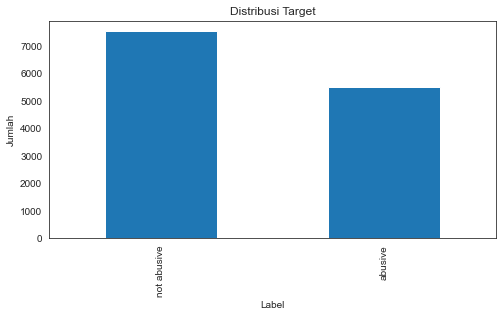

In [109]:
df_raw['abusive'].value_counts().plot.bar(figsize=(8, 4));

plt.title('Distribusi Target');
plt.xlabel('Label');
plt.ylabel('Jumlah');

Distribusi label kelas abusive dan not abusive tidak seimbang. Kelas not abusive lebih dominan. 

#### Distribusi Label Hate Speech Berdasarkan Kategori

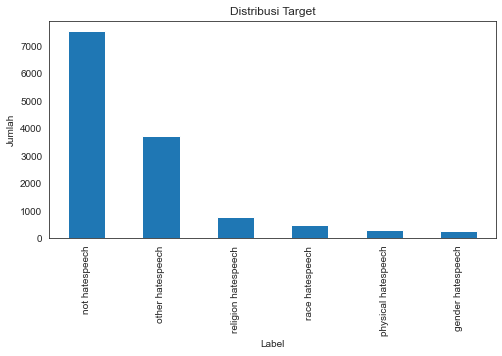

In [110]:
df_raw['hate_speech_categories'].value_counts().plot.bar(figsize=(8, 4));

plt.title('Distribusi Target');
plt.xlabel('Label');
plt.ylabel('Jumlah');

Jika dilihat dari grafik dengan mengesampingkan kelas not hatespeech, kategori atau topik hatespeech juga memiliki proporsi yang imbalance. Pada mayoritas kelas bahkan data yang dimiliki kurang dari 1000. Tentunya ini menjadi salah satu batasan yang terdapat pada dataset. 

#### Distribusi Label Hate Speech Berdasarkan Target

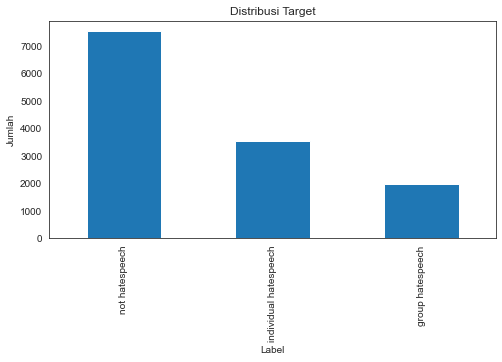

In [111]:
df_raw['hate_speech_target'].value_counts().plot.bar(figsize=(8, 4));

plt.title('Distribusi Target');
plt.xlabel('Label');
plt.ylabel('Jumlah');

Distribusi kelas hatespeech individual dan group juga cukup tidak seimbang.

#### Distribusi Label Hate Speech Berdasarkan Keparahan

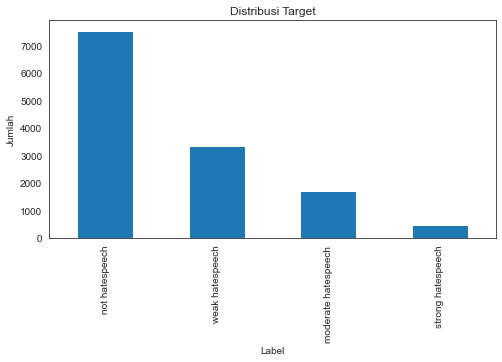

In [112]:
df_raw['hate_speech_severity'].value_counts().plot.bar(figsize=(8, 4));

plt.title('Distribusi Target');
plt.xlabel('Label');
plt.ylabel('Jumlah');

Distribusi kelas hatespeech berdasarkan severity juga cukup tidak seimbang. Kelas hatespeech strong menjadi sangat minoritas.

### Analisis Korelasi

#### Korelasi Fitur
Untuk menganalisis mengenai hubungan antar fitur yang terdapat pada data, dapat dilakukan visualisasi korelasi sederhana. Untuk mempermudah, digunakan pustaka pandas-profiling untuk mendapatkan korelasi Cramers (data kategorikal).

In [113]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_raw, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Berdasarkan korelasi Crammer, terlihat korelasi antara fitur abusive dan hatespeech sangat tinggi. Pendeteksian abusive juga cenderung lebih mudah dengan mendefinisikan daftar kata yang merupakan kata abusive dan membuat rule based classifier. Berdasarkan analisis distribusi antar kelas yang telah dilakukan, ditemukan bahwa proporsi data untuk pekerjaan klasifikasi hatespeech dengan tambahan informasi topik, target, dan keparahan masih sangat kurang seimbang. Pada analisis selanjutnya, akan difokuskan analisis mengenai informasi **hatespeech** dan **kategori/topik**-nya. 

### Distribusi Panjang Kata Pesan

In [114]:
df_raw['text_length'] = df_raw.apply(lambda row: len(row.text.split()), axis=1)

#### Keseluruhan Data

Boxplot Persebaran Panjang Kalimat

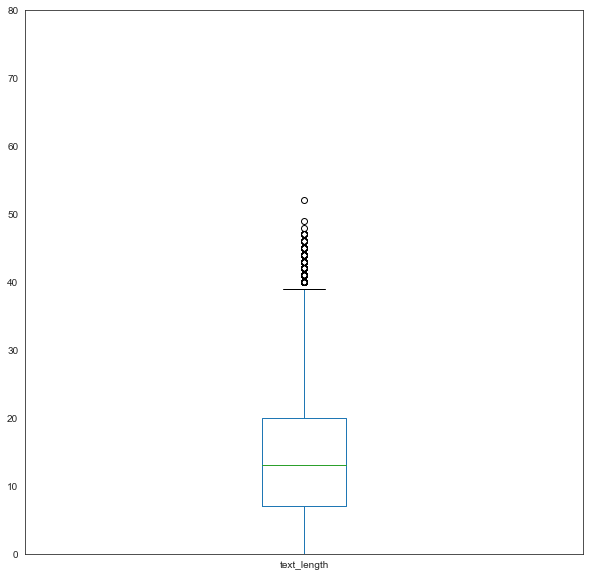

In [115]:
disp = df_raw.boxplot(column = ['text_length'], grid = False, figsize=(10, 10))
plt.ylim(0, 80)
plt.show();

Histogram Distribusi Panjang Data

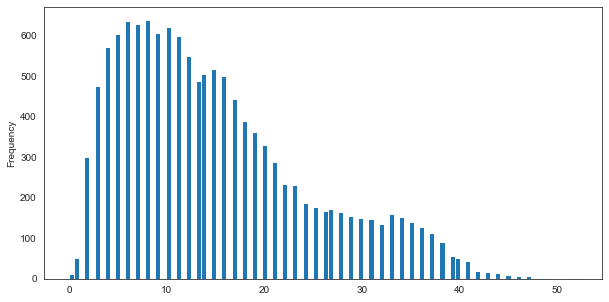

In [116]:
df_raw['text_length'].plot.hist(bins=100, figsize=(10, 5))
plt.show();

Berdasarkan visualisasi boxplot dan histogram, didapatkan bahwa panjang pesan cukup beragam. Dapat dilihat pada boxplot diatas panjang kata memiliki median yang berada sekitar 13 kata dan distribusinya lebih dekat ke kurang lebih 10 kata. Kata diatas 40 kata sudah mulai jarang sehingga terdeteksi sebagai pencilan. Informasi ini dapat menjadi bahan pemotongan jumlah kata jika nantinya diperlukan.

Boxplot Persebaran Panjang Kalimat Per Label

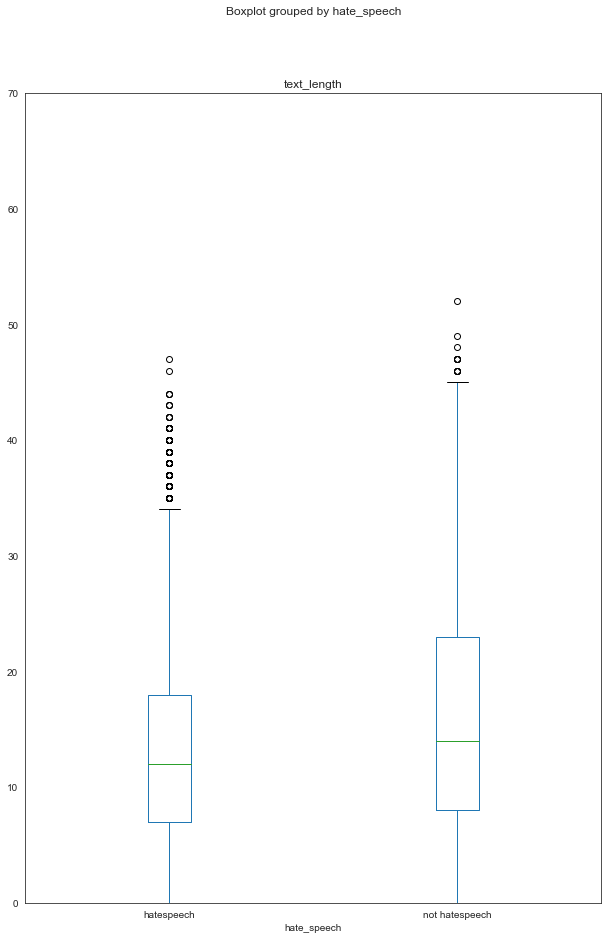

In [117]:
disp = df_raw.boxplot(by ='hate_speech', column=['text_length'], grid = False, figsize=(10, 15))
plt.ylim(0, 70)
plt.show();

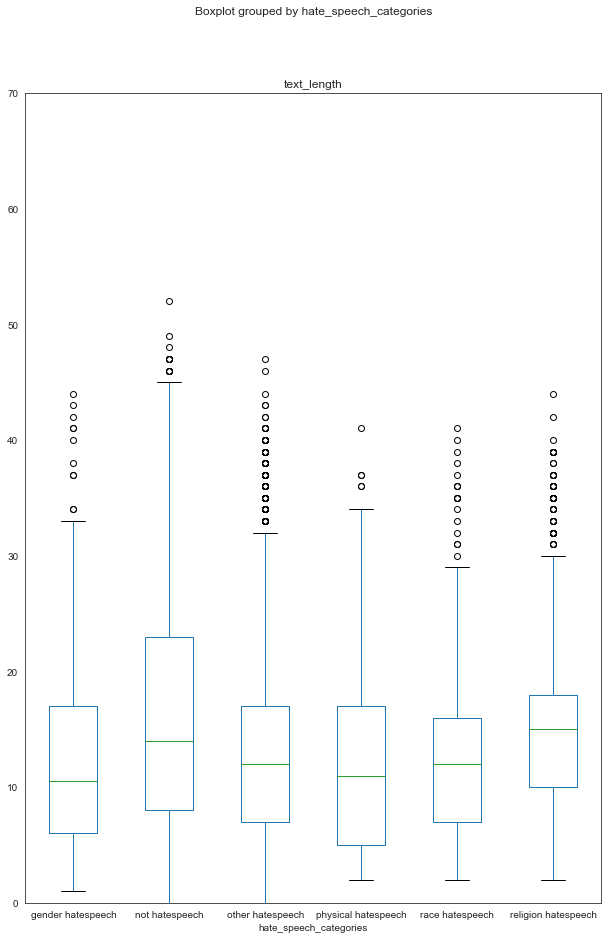

In [118]:
disp = df_raw.boxplot(by ='hate_speech_categories', column=['text_length'], grid = False, figsize=(10, 15))
plt.ylim(0, 70)
plt.show();

### Distribusi Kata
Untuk setiap kelasnya, coba dianalisis kata-kata yang dominan dengan menggunakan wordcloud. Beberapa kata yang kurang merepresentasikan tiap kelas nantinya akan ditambahkan ke dalam STOPWORDS. Selain itu juga ditampilkan 20 bigram teratas untuk memperlihatkan kemunculan bigram penanda kelas.

#### Distribusi Kata Keseluruhan Data

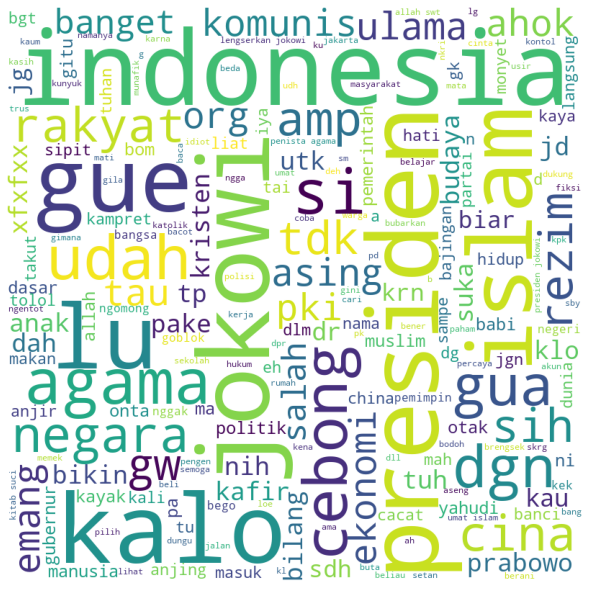

In [119]:
show_wordcloud(df_raw['text'])

#### Distribusi Kata Kelas Hate Speech

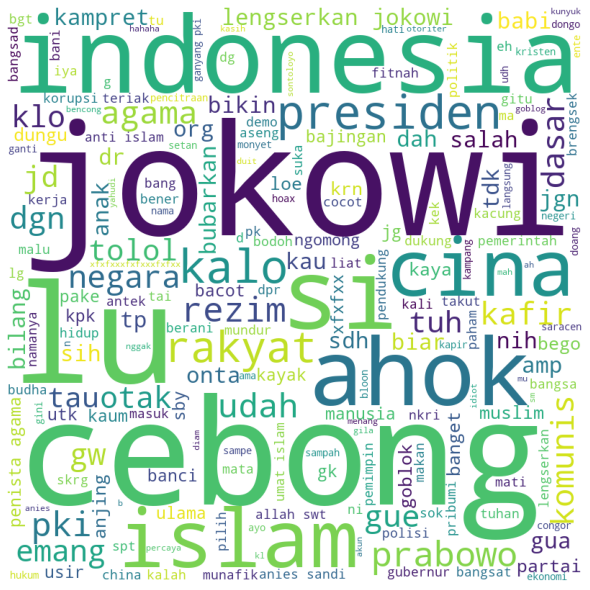

In [120]:
show_wordcloud(df_raw[df_raw['hate_speech'] == 'hatespeech']['text'])

In [121]:
show_top_ngram(df_raw[df_raw['hate_speech'] == 'hatespeech']['text'])[:20]

frequency     bigram/trigram
0   21.329327  lengserkan jokowi
1   14.389904      penista agama
2   13.242408        ganyang pki
3   12.553512          allah swt
4   12.345154         anti islam
5   12.062217        anies sandi
6   10.934123       di indonesia
7    8.987736      antek komunis
8    8.490466          rezim ini
9    8.247180         pak jokowi
10   7.991408         umat islam
11   7.833125       bani kampret
12   7.780862       bubarkan dpr
13   7.462430       bubarkan kpk
14   7.079852      teroris budha
15   6.880715         lebih baik
16   6.501716         rezim anti
17   6.250931          usir cina
18   6.210343        di bubarkan
19   6.156817    turunkan jokowi

#### Distribusi Kata Kelas Non Hate Speech

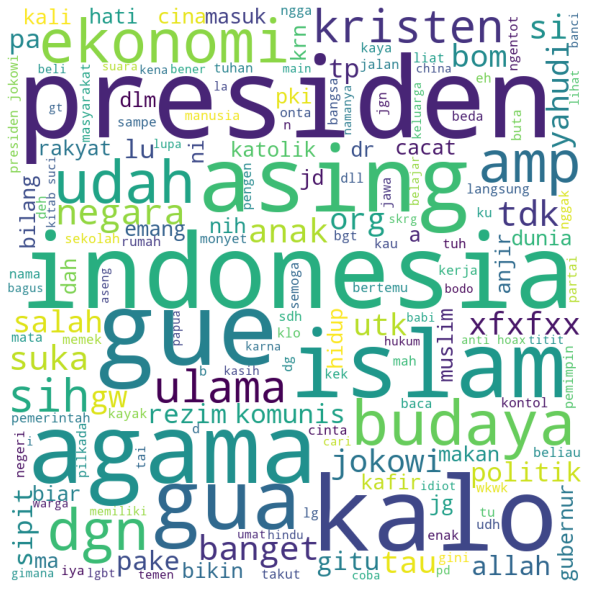

In [122]:
show_wordcloud(df_raw[df_raw['hate_speech'] == 'not hatespeech']['text'])

In [124]:
show_top_ngram(df_raw[df_raw['hate_speech'] == 'not hatespeech']['text'])[:20]

frequency   bigram/trigram
0   13.567848  presiden jokowi
1   13.423907        anti hoax
2   12.502491         hari ini
3    9.527593    pilkada damai
4    8.936538     di indonesia
5    8.637033  gubernur banten
6    8.354688         aman dan
7    7.975274    jadi presiden
8    7.943915         ada yang
9    7.542268         dan anti
10   7.342621       orang yang
11   7.309529       kitab suci
12   7.204430     pilkada aman
13   6.976871       jawa barat
14   6.674163       salah satu
15   6.636706    wahidin halim
16   6.636706   banten wahidin
17   6.581328         hoax dan
18   6.560761   bertemu dengan
19   6.424474  islam nusantara

#### Distribusi Kata Kelas Hate Speech Religion

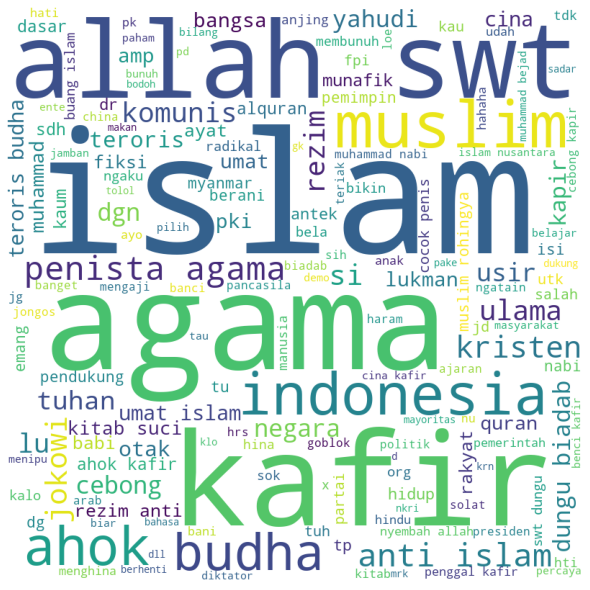

In [125]:
show_wordcloud(df_raw[df_raw['hate_speech_categories'] == 'religion hatespeech']['text'])

In [126]:
show_top_ngram(df_raw[df_raw['hate_speech_categories'] == 'religion hatespeech']['text'])[:10]

frequency   bigram/trigram
0  10.307751        allah swt
1   9.117479       anti islam
2   7.808976    penista agama
3   6.255542    teroris budha
4   5.418826     dungu biadab
5   5.165562       rezim anti
6   3.951447       umat islam
7   3.908888       pak lukman
8   3.781249  muslim rohingya
9   3.645019     di indonesia

#### Distribusi Kata Kelas Hate Speech Race

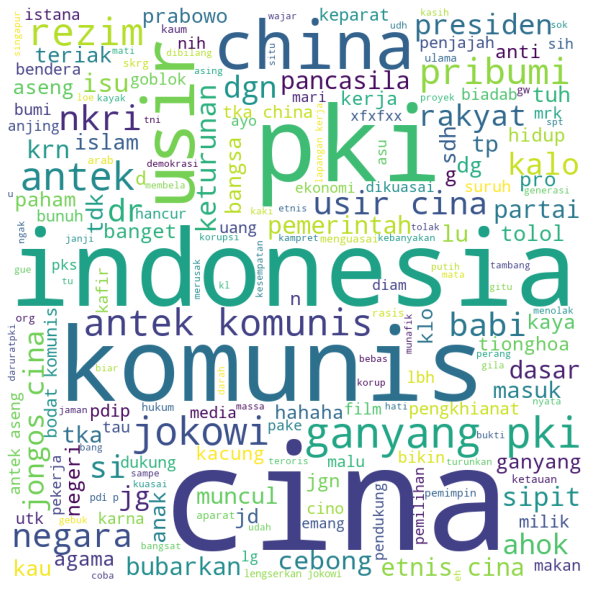

In [127]:
show_wordcloud(df_raw[df_raw['hate_speech_categories'] == 'race hatespeech']['text'])

In [128]:
show_top_ngram(df_raw[df_raw['hate_speech_categories'] == 'race hatespeech']['text'])[:10]

frequency  bigram/trigram
0  10.047044     ganyang pki
1   6.621983   antek komunis
2   5.375685       usir cina
3   4.821459    di indonesia
4   3.989932     jongos cina
5   3.649323   bodat komunis
6   2.972911    cina komunis
7   2.951288       cina dari
8   2.436729  dari indonesia
9   2.350426        cina dan

#### Distribusi Kata Kelas Hate Speech Gender

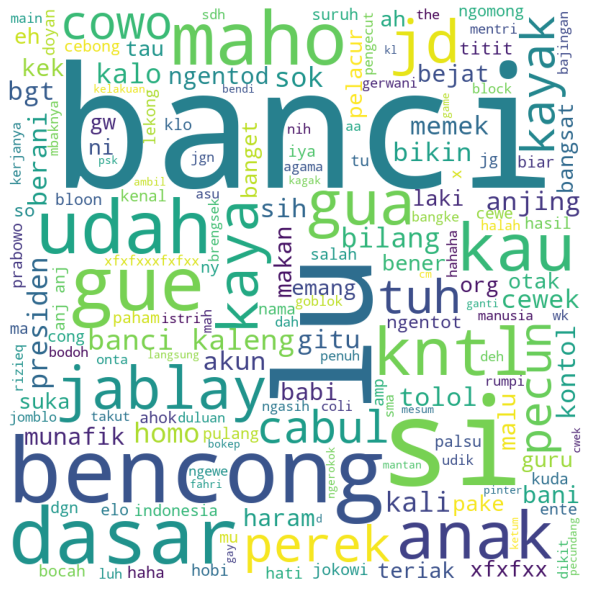

In [129]:
show_wordcloud(df_raw[df_raw['hate_speech_categories'] == 'gender hatespeech']['text'])

In [130]:
show_top_ngram(df_raw[df_raw['hate_speech_categories'] == 'gender hatespeech']['text'])[:10]

frequency bigram/trigram
0   3.303612   banci kaleng
1   1.552017     kaya banci
2   1.230925   dasar jablay
3   1.154701       udik gay
4   1.154701      udah udik
5   1.154701       gay lagi
6   1.018503       gak usah
7   1.000000        lu maho
8   1.000000     halah kntl
9   1.000000       dih kntl

#### Distribusi Kata Kelas Hate Speech Physical

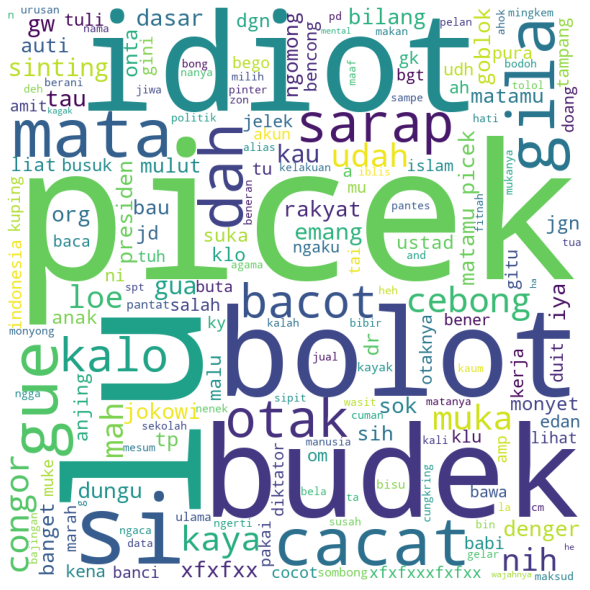

In [131]:
show_wordcloud(df_raw[df_raw['hate_speech_categories'] == 'physical hatespeech']['text'])

In [132]:
show_top_ngram(df_raw[df_raw['hate_speech_categories'] == 'physical hatespeech']['text'])[:10]

frequency bigram/trigram
0   3.359185   matamu picek
1   2.015962     orang gila
2   1.879478    wasit picek
3   1.533823     mata picek
4   1.422619   matalu picek
5   1.415770       ni orang
6   1.389145        mata lu
7   1.232566   bolot banget
8   1.228837      wong edan
9   1.104657     budek kamu

#### Distribusi Kata Kelas Hate Speech Other

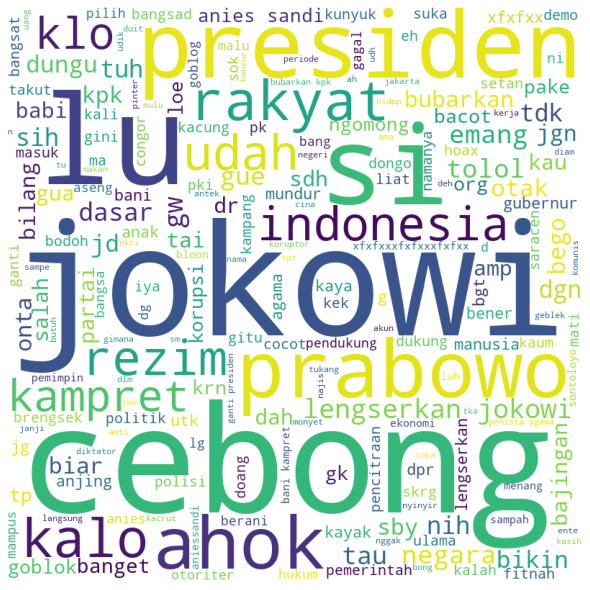

In [133]:
show_wordcloud(df_raw[df_raw['hate_speech_categories'] == 'other hatespeech']['text'])

In [134]:
show_top_ngram(df_raw[df_raw['hate_speech_categories'] == 'other hatespeech']['text'])[:10]

frequency     bigram/trigram
0  19.269470  lengserkan jokowi
1  11.465738        anies sandi
2   7.692305       bubarkan dpr
3   7.588720         pak jokowi
4   7.476326       bani kampret
5   7.346921       bubarkan kpk
6   6.180408      penista agama
7   5.924165         lebih baik
8   5.758726          rezim ini
9   5.489305         rt prabowo